In [1]:
import pandas as pd  # For manipulating data structures
import numpy as np  # For mathematical functions
import scipy.stats as stats  # Algorithms and convenience functions built on NumPy
import statsmodels.api as sm  # For statistical methods
import matplotlib.pyplot as plt  # Essentially the Python equivalent to ggplot2
import seaborn as sns  # A library for statistical graphics built on Matplotlib

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme(
    context="notebook",
    style="ticks",
    palette="colorblind",
    rc=custom_params,
)

scavengers = pd.read_csv("../data/cleaned scavenger data.csv", index_col="Species name")

scavengers.drop(
    ["BirdLife Extent of occurrence"], axis=1, inplace=True
)

Text(0.02, 0.5, 'Number of species')

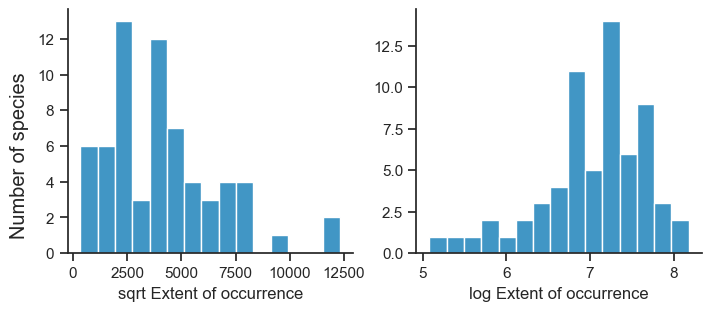

In [2]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(7,3), layout="constrained")

sns.histplot(
    ax=ax1,
    data=scavengers,
    x=np.sqrt(scavengers["Extent of occurrence"]),
    bins=15,
)
sns.histplot(
    ax=ax2,
    data=scavengers,
    x="log Extent of occurrence",
    bins=15
)
ax1.set_xlabel("sqrt Extent of occurrence")
ax1.set_ylabel("")
ax2.set_ylabel("")
fig.supylabel("Number of species")

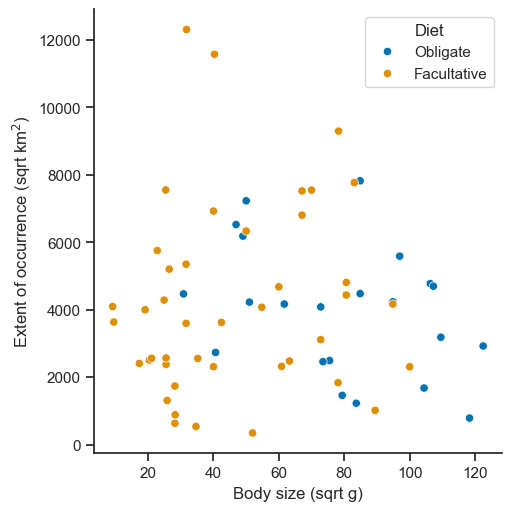

In [3]:
fig, ax = plt.subplots(1,1, figsize=(5,5), layout="constrained")

sns.scatterplot(
    data=scavengers,
    x=np.sqrt(scavengers["Body size"]),
    y=np.sqrt(scavengers["Extent of occurrence"]),
    hue="Diet",
)
ax.set_ylabel("Extent of occurrence (sqrt km$^2$)")
ax.set_xlabel("Body size (sqrt g)")
plt.show()

Check whether the log-transformed data have the skewness and kurtosis of a normal distribution.

The Raw Data Jarque-Bera test statistic below concurs with the above histograms that our data distribution is not normally distributed when examining all scavengers as a single group, but are normally distributed when log-transformed.

Note that I should only take this test with a grain of salt, because the sample size is much smaller than what is advised (>2000).

In [5]:
body_jb_test = stats.jarque_bera(x=(scavengers["log Body size"]))

eoo_jb_test = stats.jarque_bera(x=scavengers["log Extent of occurrence"])

print(f"log body size Jarque-Bera Test:\nStatistic: {body_jb_test.statistic:.2f}, p-value: {body_jb_test.pvalue:.5f}")

print(f"log EOO Jarque-Bera Test:\nStatistic: {eoo_jb_test.statistic:.2f}, p-value: {eoo_jb_test.pvalue:.5f}")

log body size Jarque-Bera Test:
Statistic: 4.07, p-value: 0.13076
log EOO Jarque-Bera Test:
Statistic: 9.46, p-value: 0.00884


Check whether the log-transformed data have the skewness and kurtosis of a normal distribution. I selected the Shapiro-Wilk test because it is better suited for small sample sizes than something like the Jarque-Bera test, which is better suited for >2000 samples for the `jarque-bera` test from Statsmodels.

In [4]:
body_shapiro = stats.shapiro(x=(scavengers["log Body size"]))

eoo_shapiro = stats.shapiro(x=scavengers["log Extent of occurrence"])

print(f"log body size Shapiro-Wilk test:\nStatistic: {body_shapiro.statistic:.2f}, p-value: {body_shapiro.pvalue:.5f}")

print(f"log EOO Shapiro-Wilk test:\nStatistic: {eoo_shapiro.statistic:.2f}, p-value: {eoo_shapiro.pvalue:.5f}")

log body size Shapiro-Wilk test:
Statistic: 0.95, p-value: 0.00675
log EOO Shapiro-Wilk test:
Statistic: 0.95, p-value: 0.00790


In [6]:
# Define the X and Y matrices
y = scavengers["log Extent of occurrence"]
x = scavengers["log Body size"]

# Add a column called "const" to the design matrix.
x = sm.add_constant(x)
x.head()

ols_model = sm.OLS(y, x).fit()

<Axes: >

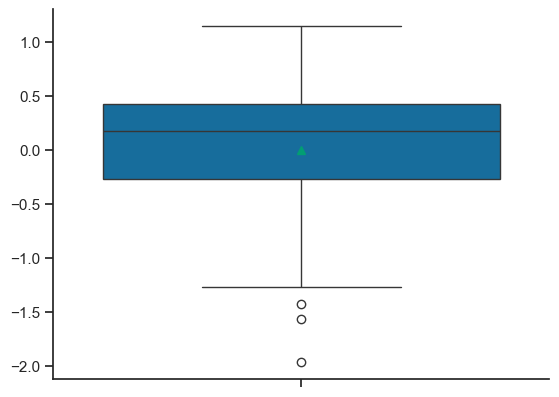

In [7]:
sns.boxplot(ols_model.resid, showmeans=True)